In [13]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter
import torch.profiler

from GPUtil import showUtilization as gpu_usage

Using torch 1.13.1


In [14]:
class langevin_sampler():
    def __init__(self, sampling_steps, sampling_noise, device):
        self.device = device
        self.K = torch.tensor(sampling_steps, device=self.device)
        self.s = torch.tensor(sampling_noise, device=self.device)
    
    def get_sample(self, initial_sample, model, x):
        x_k = initial_sample
        z_k = x
        step=0
        
        while step < self.K:
            # Compute gradient
            grad = model.grad_log_fn(x_k, z_k)
            
            # Update sample
            x_k = x_k + self.s * grad + (torch.sqrt(2*self.s)*torch.randn_like(x_k, device=self.device))  
            
            step += 1             
        
        return x_k, grad

In [15]:
class priorEBM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256),  # Increase the number of units in the first layer
                    nn.ReLU(),
                    nn.Linear(256, 128),  # Adjust the number of units based on the complexity
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                    nn.Tanh()  # Use an appropriate activation function based on the desired range
                )
            
    def forward(self, x):
        # Returns f_a(z)
        return self.layers(x)
    
    # def grad_log_fn(self, z, x):
    #     f_z = self.forward(z)
    #     grad_f_z = torch.autograd.grad(outputs=f_z, inputs=z, grad_outputs=torch.ones_like(f_z), create_graph=True)[0]
    #     return grad_f_z - z
    
    def grad_log_fn(self, z, x):
        f_z = self.forward(z)
        grad_f_z = torch.autograd.grad(f_z.sum(), z, create_graph=True)[0]
        return grad_f_z

In [16]:
class topdownGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, sample_noise, SIGMA):
        super().__init__()
        self.s = sample_noise
        self.sigma = SIGMA
        self.grad_log_prior = 0
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                    nn.Tanh()  
                )
    
    def forward(self, z):
        g_z = self.layers(z)
        return g_z + self.sigma*torch.randn_like(g_z)
    
    # def grad_log_fn(self, z, x):
    #     g_z = self.forward(z)
    #     grad_g_z = torch.autograd.grad(outputs=g_z, inputs=z, grad_outputs=torch.ones_like(g_z), create_graph=True)[0]
    #     return grad_g_z * (x - g_z) / (self.sigma**2) - z
    
    def grad_log_fn(self, z, x):
        g_z = self.forward(z)
        log_gz = -(1.0 / (2.0 * self.sigma * self.sigma)) * torch.mean((x - g_z)**2)
        grad_log_gz = torch.autograd.grad(log_gz.sum(), z, create_graph=True)[0]
        return grad_log_gz + self.grad_log_prior # This is log[ p(x | z) * p(z) ]

In [17]:
def generator_loss(x, x_pred, sigma):
    neg_log_likelihood = 0.5 * torch.square(x - x_pred) / sigma**2
    return torch.mean(neg_log_likelihood)

def EBM_loss(z_prior, z_posterior, EBMmodel):
            en_neg = torch.mean(EBMmodel(z_prior.detach()), dim=0)
            en_pos = torch.mean(EBMmodel(z_posterior.detach()), dim=0)

            return (en_neg - en_pos).sum()

  0%|          | 0/10000 [00:00<?, ?it/s]

STAGE:2023-11-09 16:41:43 2512584:2512584 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-11-09 16:41:43 2512584:2512584 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-11-09 16:41:47 2512584:2512584 output_json.cpp:417] Completed Stage: Post Processing


KeyboardInterrupt: 

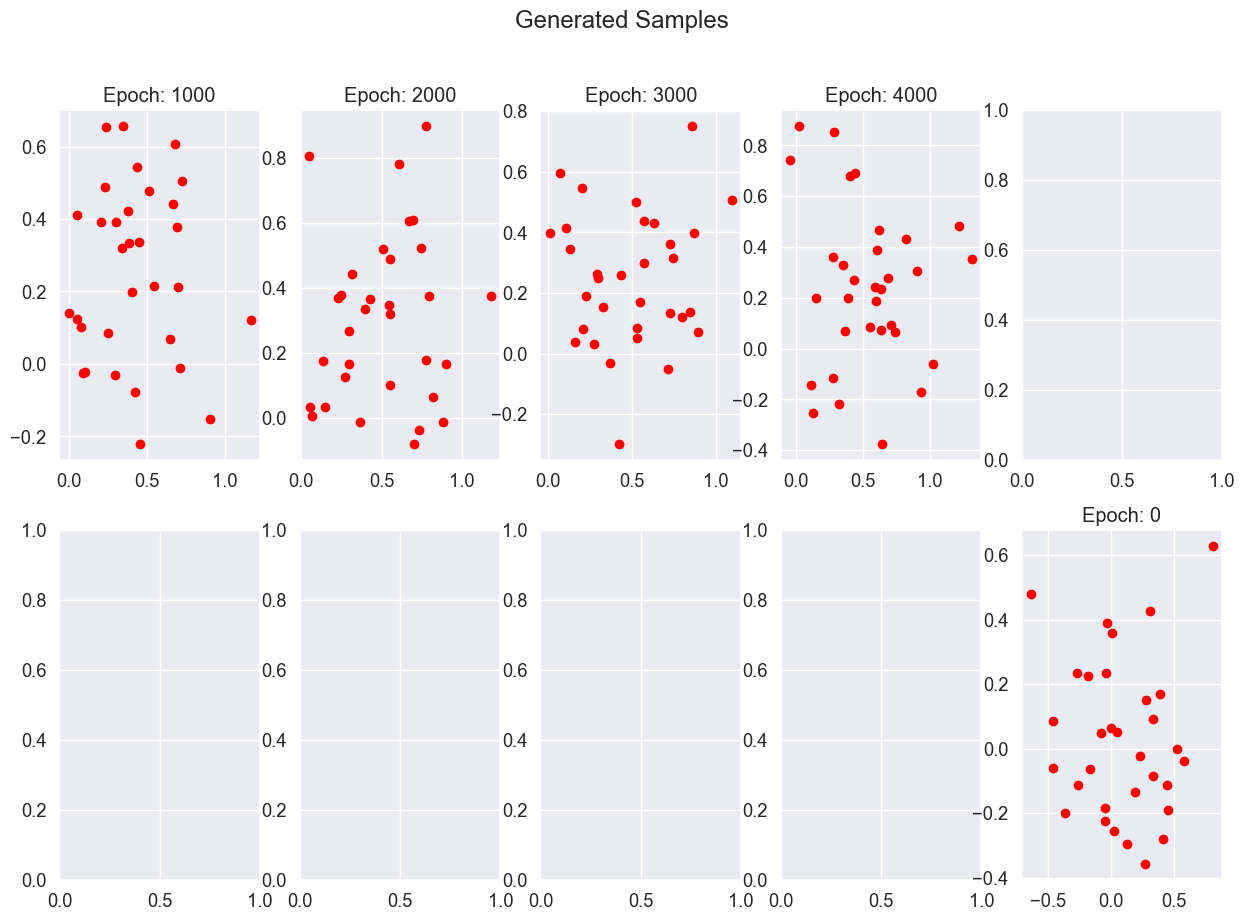

In [18]:
NUM_EPOCHS = 10000
BATCH_SIZE = 32
E_LR = 0.00002
G_LR = 0.0001
SAMPLE_STEPS = 20
SAMPLES = 5000
SIGMA = 0.3
SAMPLE_NOISE = 0.1

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the moons dataset
X, _ = make_moons(n_samples=SAMPLES, noise=0.05, random_state=42)
X = torch.tensor(X).float().to(device)
loader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)

# Create the model and optimizer
EBMmodel = priorEBM(X.shape[1], X.shape[1]).to(device)
GENmodel= topdownGenerator(X.shape[1], X.shape[1], SAMPLE_NOISE, SIGMA).to(device)
Sampler = langevin_sampler(SAMPLE_STEPS, SAMPLE_NOISE, device)

EBMoptimiser = torch.optim.Adam(EBMmodel.parameters(), lr=E_LR)
EBMlossfn = EBM_loss

GENoptimiser = torch.optim.Adam(GENmodel.parameters(), lr=G_LR)
GENlossfn = generator_loss

# Write to tensorboard 10 times
sample_every = NUM_EPOCHS//10
writer = SummaryWriter(f"runs/VanillaEBM")
num_plots = (NUM_EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(NUM_EPOCHS))

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs/VanillaEBM/profilerlogs'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    for epoch in tqdm_bar:
        total_loss = 0
        for batch_idx, x in enumerate(loader): 
            batch_size = x.shape[0]
            
            # 1a. Sample from latent prior
            z0_noise = torch.randn_like(x, device=device, requires_grad=True)

            # 1b. Expontentially tilt z, sample from posterior
            z_prior, grad_log_prior = Sampler.get_sample(z0_noise, EBMmodel, None) # p(z|M)
            GENmodel.grad_log_prior = grad_log_prior # The gradient of the log prior is in the grad_log function of the generator
            z_posterior, _ = Sampler.get_sample(z_prior, GENmodel, x) # p(z|x, M)
            
            # 2. Forward pass on generation
            x_pred = GENmodel(z_posterior)

            # 3. Compute generation loss
            loss_g = generator_loss(x, x_pred, SIGMA)

            # 4. Backpropagation
            GENoptimiser.zero_grad()
            loss_g.backward()

            # 5. Update weights
            GENoptimiser.step()

            # 6. Compute EBM loss
            EBMoptimiser.zero_grad()
            loss_e = EBMlossfn(z_prior, z_posterior, EBMmodel)
            loss_e.backward()

            # 7. Update weights
            EBMoptimiser.step()

            total_loss += loss_g.item() + loss_e.item()
            
            prof.step()
            if batch_idx >= 1 + 1 + 3:
                break

        tqdm_bar.set_description(f"Epoch {epoch}: Loss: {total_loss / (BATCH_SIZE):.4f}")

        if epoch % sample_every == 0 or epoch == NUM_EPOCHS:
            
            # Need gradients for langevin sampling
            z0_noise = torch.randn_like(x, device=device, requires_grad=True)
            z_prior, grad = Sampler.get_sample(z0_noise, EBMmodel, None) # p(z|M)

            with torch.no_grad():
                GENmodel.grad_log_prior = grad
                x = GENmodel(z_prior)
                samples = x.detach().cpu()

                plot_num = (epoch // sample_every) - 1
                row = plot_num // num_cols
                col = (plot_num % num_cols)
                axs[row, col].clear()
                axs[row, col].scatter(x=samples[:, 0].numpy(), y=samples[:, 1].numpy(), color='red', marker='o')
                axs[row, col].set_title(f'Epoch: {epoch}')

                # Convert the Matplotlib figure to a NumPy array
                fig.canvas.draw()
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                # Write the image to TensorBoard
                writer.add_image("VanillaEBM -- Make Moons", image, global_step=epoch, dataformats='HWC')
